# SALES ANALYSIS 2019 - FULL NOTEBOOK

In [ ]:
### 1. Import Libraries
### Load essential Python libraries for data processing and visualization.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('ggplot')
sns.set_context('notebook')

### 2. Load and Merge Raw Data
### Merge 12 separate monthly sales CSVs into one complete DataFrame.

In [9]:
raw_folder = '../data/raw/'
all_files = [f for f in os.listdir(raw_folder) if f.endswith('.csv')]
df_list = [pd.read_csv(os.path.join(raw_folder, file)) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

# os.makedirs('data/processed', exist_ok=True)
df.to_csv('../data/processed/annualSales2019_finished.csv', index=False)

### 3. Data Cleaning
### Clean raw data by handling missing values, converting data types, and extracting useful columns.

In [10]:
df.dropna(how='all', inplace=True)
df = df[df['Order Date'].str[:2] != 'Or']

# Convert data types
df['Order ID'] = pd.to_numeric(df['Order ID'], errors='coerce')
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')

# Parse datetime & extract features
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M')
df['Month'] = df['Order Date'].dt.month
df['Hour'] = df['Order Date'].dt.hour

def extract_city(address):
    try:
        return address.split(',')[1].strip()
    except:
        return None

df['City'] = df['Purchase Address'].apply(extract_city)
df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df.to_csv('../data/processed/annualSales2019_cleaned.csv', index=False)

### 4. Exploratory Data Analysis (EDA)
### Explore trends in revenue across months, cities, hours, and products.

### 4.1 Sales by Month
# Identify monthly sales patterns.

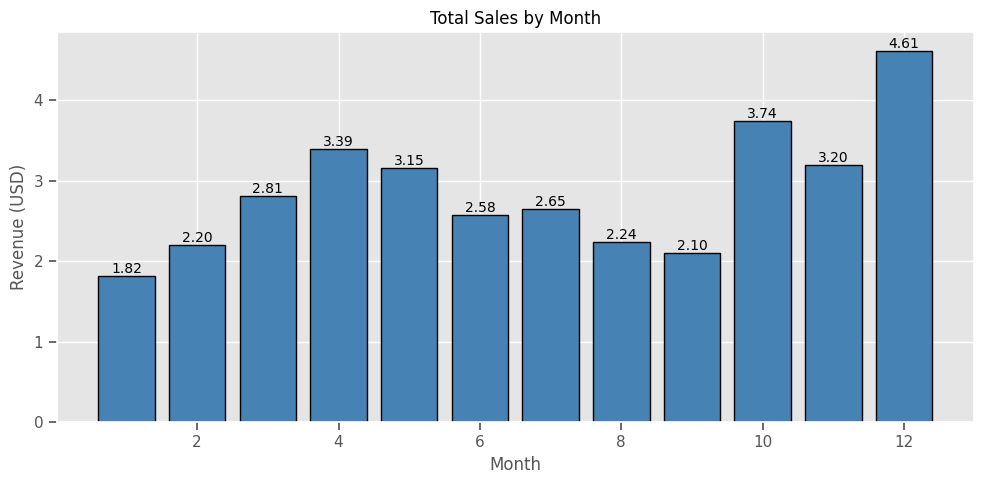

In [24]:
monthly_sales = df.groupby('Month')['Sales'].sum()/1e6
plt.figure(figsize=(10,5))
bars = plt.bar(monthly_sales.index, monthly_sales.values, color='steelblue', edgecolor='black')

for bar, sales in zip(bars, monthly_sales.values):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{sales:,.2f}',
             ha='center',
             va='bottom',
             fontsize=10,
             color='black')

plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 📌 Insight: Sales theo tháng
Data: Doanh số tăng dần từ tháng 1 và đạt đỉnh vào tháng 12 (~4.61 triệu USD).  
Context: Tháng 12 là mùa mua sắm (Giáng sinh, cuối năm), nhu cầu tiêu dùng cao.  
Action: Doanh nghiệp nên chuẩn bị hàng hóa sớm và chạy khuyến mãi mạnh trong Q4.

### 4.2 Sales by City
# Which cities generate the most sales?

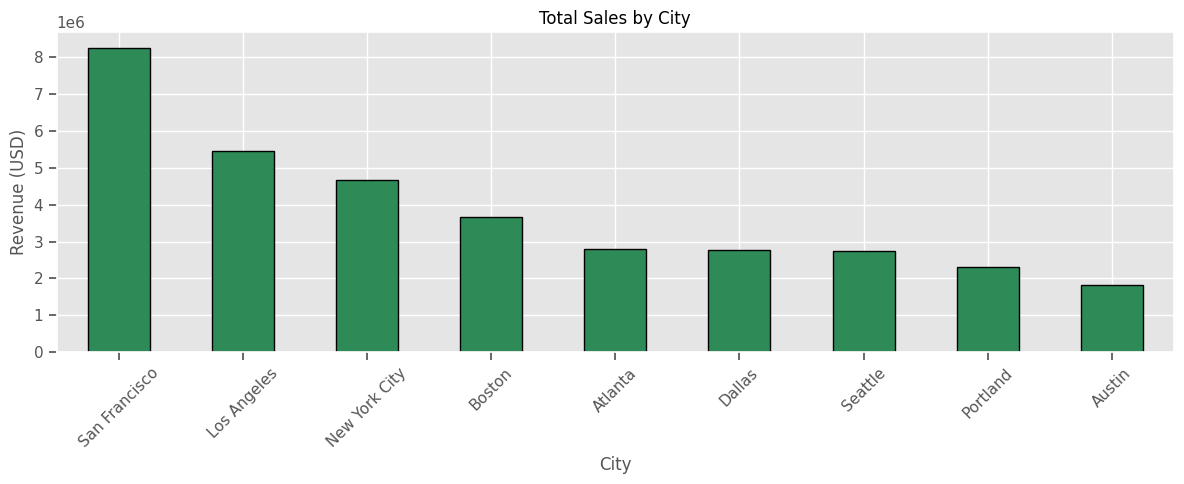

In [27]:
city_sales = df.groupby('City')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,5))
city_sales.plot(kind='bar', color='seagreen', edgecolor='black')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📌 Insight: Sales theo thành phố
Data: San Francisco dẫn đầu với hơn 8 triệu USD doanh thu, theo sau là Los Angeles và New York.

Context: Đây đều là các thành phố đông dân, có mật độ doanh nghiệp và sức mua cao.

Action: Tập trung nguồn lực tiếp thị và hậu cần tại các khu vực thành phố lớn để tối ưu hóa doanh thu.

### 4.3 Sales by Hour  
# Analyze hourly sales trends to identify peak purchasing times during the day.

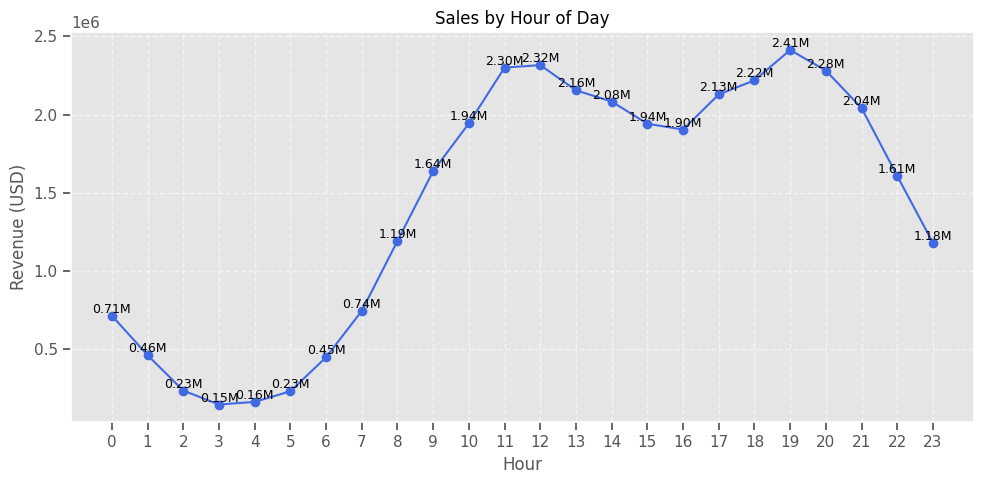

In [ ]:
hourly_sales = df.groupby('Hour')['Sales'].sum()

plt.figure(figsize=(10, 5))
plt.plot(hourly_sales.index, hourly_sales.values, marker='o', linestyle='-', color='royalblue')
plt.title('Sales by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Revenue (USD)')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)

for hour, sales in zip(hourly_sales.index, hourly_sales.values):
    plt.text(hour, sales, f'{sales/1e6:.2f}M', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### 📌 Insight: Sales theo giờ

Data: Doanh số đạt đỉnh vào hai khung giờ: 11h trưa và 19h tối.

Context: Đây là các khung thời gian người dùng thường có thời gian rảnh – nghỉ trưa và sau giờ làm việc.

Action: Tối ưu hiệu suất bán hàng bằng cách triển khai các chiến dịch quảng cáo, flash sale hoặc ưu đãi vào các khung giờ vàng này.

### 4.4 Top Selling Products
# Discover best-selling products based on quantity.

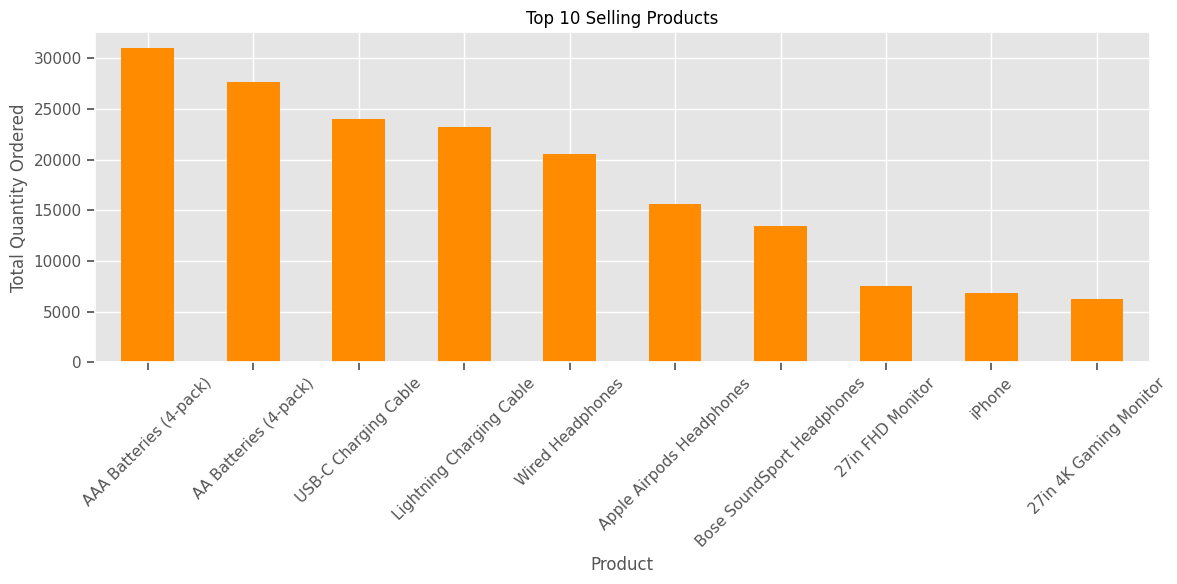

In [14]:
top_products = df.groupby('Product')['Quantity Ordered'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
top_products.plot(kind='bar', color='darkorange')
plt.title('Top 10 Selling Products')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📌 Insight: Sản phẩm bán chạy
Data: Các sản phẩm có giá phải chăng như cáp USB-C, tai nghe có dây và pin AA là những mặt hàng được mua nhiều nhất.

Context: Đây là các sản phẩm thiết yếu, giá thấp và thường được mua với số lượng lớn hoặc lặp lại nhiều lần.

Action: Tập trung trữ kho các sản phẩm này, đóng gói thành các combo nhiều chiếc và áp dụng ưu đãi theo số lượng để gia tăng tổng doanh thu.



### 5. Statistical Modeling: Linear Regression
# Analyze the effect of price, quantity, and hour on total sales.

In [16]:
import statsmodels.api as sm

features = df[['Price Each', 'Quantity Ordered', 'Hour']]
features = sm.add_constant(features)
target = df['Sales']

model = sm.OLS(target, features)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.084e+07
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:55:34   Log-Likelihood:            -7.4024e+05
No. Observations:              185950   AIC:                         1.480e+06
Df Residuals:                  185946   BIC:                         1.481e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.6324      0.118  

### 📌 Insight: Mô hình hồi quy tuyến tính

**Data**: Mô hình hồi quy tuyến tính cho thấy hệ số xác định R-squared đạt 0.998, chứng tỏ các biến đầu vào như Price Each, Quantity Ordered và Hour có khả năng giải thích gần như toàn bộ biến động doanh thu.
**Context**: Trong đó, Quantity Ordered có ảnh hưởng lớn nhất (hệ số ~6.76), tiếp theo là Price Each, còn Hour có tác động nhỏ nhưng vẫn mang ý nghĩa thống kê. 
**Action**: Mô hình này phù hợp để diễn giải mối quan hệ giữa các yếu tố đầu vào và doanh thu, hỗ trợ ra quyết định trong chiến lược giá và thời điểm bán hàng.


6. Machine Learning Model: Predicting Sales
# Use Random Forest to predict revenue for each order.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df[['Price Each', 'Quantity Ordered', 'Hour']]
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2_score(y_test, y_pred):.4f}")

RMSE: 0.81
R-squared: 1.0000


### 📌 Insight: Mô hình học máy dự đoán doanh thu

**Data**: Mô hình Random Forest đạt độ chính xác rất cao với R-squared = 1.000 và RMSE = 0.81, cho thấy khả năng dự đoán doanh thu theo đơn hàng gần như tuyệt đối.
**Context**: Đây là kết quả vượt trội so với mô hình hồi quy tuyến tính, cho thấy tiềm năng áp dụng Machine Learning trong dự báo doanh số. 
**Action**: Có thể ứng dụng mô hình này để xây dựng hệ thống dự báo doanh thu theo đơn hàng theo thời gian thực, phục vụ cho lập kế hoạch kho, marketing và tài chính.


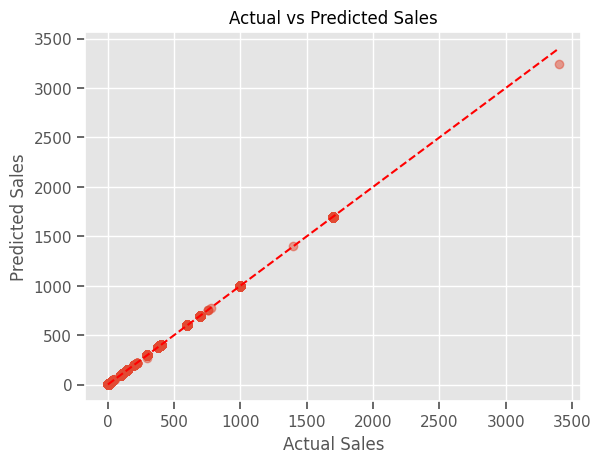

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.show()


### 7. Conclusion

This project provides a comprehensive analysis of sales data from 2019 using both statistical and machine learning approaches. Key findings are summarized below:

#### 🔍 Data:
- December is the peak revenue month, and 11 AM and 7 PM are the hours with highest sales.
- Major cities such as San Francisco and Los Angeles generate the most revenue.
- Key factors that significantly impact sales include product price, quantity ordered, and time of purchase.

#### 📌 Context:
- Most customers tend to place orders during lunch breaks and after work hours.
- Frequently purchased items are essential, affordable, and often bought in bulk — possibly by groups or offices.

#### 🎯 Action:
- Increase operational capacity and stock preparation before December and during daily peak hours.
- Schedule marketing campaigns strategically at 11 AM and 7 PM.
- Consider bundling popular items into volume-based promotional packages, especially in high-sales cities.

#### 📈 Modeling Summary:
- **Linear Regression**: Achieved an R² of **0.998**, showing strong explanatory power. Quantity Ordered was the most influential variable.
- **Random Forest Regression**: Delivered near-perfect performance with **R² = 1.000** and **RMSE ≈ 0.81**, making it suitable for accurate revenue prediction on new orders.
